<a href="https://colab.research.google.com/github/Jana-Z/GRL_final/blob/main/GRL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

In [ ]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import torch_geometric.nn.models as models
import torch_geometric.nn as geometric_nn
import torch
import torch.nn as nn
import copy
import torch_geometric.transforms as T
import torch_geometric.utils as utils
import os.path as osp

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Mitigating Over-Squashing in GNNs

## Define Models

Study the following models:
- GIN
- GCN
- GAT
- GraphSAGE

In [ ]:
def get_conv(conv_name):
  if conv_name == "GCN":
    return geometric_nn.conv.GCNConv
  elif conv_name == "GIN":
    return geometric_nn.conv.GINConv
  elif conv_name == "SAGE":
    return geometric_nn.conv.SAGEConv
  elif conv_name == "GAT":
    return geometric_nn.conv.GATConv
  else:
    raise Exception(f'{conv_name} not supported')

In [ ]:
def get_dense_conv(conv_name):
  if conv_name == "GCN":
    return geometric_nn.dense.DenseGCNConv
  elif conv_name == "GIN":
    return geometric_nn.dense.DenseGINConv
  elif conv_name == "SAGE":
    return geometric_nn.dense.DenseSAGEConv
  elif conv_name == "GAT":
    return geometric_nn.dense.DenseGATConv
  else:
    raise Exception(f'{conv_name} not supported')

In [ ]:
class BaselineModel(nn.Module):
  def __init__(
      self,
      conv_name,
      input_dim: int,
      hid_dim: int,
      n_layers: int,
      last_layer_dense: bool = False,
      n_classes: int = 1,
      dropout_ratio: float = 0.1):
    super(BaselineModel, self).__init__()
    model = nn.Sequential()
    layers = []
    conv = get_conv(conv_name)

    if n_layers == 0:
      layers.extend([
          (nn.Identity(), 'x -> x')
      ])
    for x in range(n_layers):
      in_dim = input_dim if x == 0 else hid_dim
      if x == n_layers-1 and last_layer_dense:
        dense_conv = get_dense_conv(conv_name)
        layers.extend([
            (nn.Dropout(dropout_ratio), 'x -> x'),
            (utils.to_dense_batch, 'x, batch -> x, mask'),
            (utils.to_dense_adj, 'edge_index, batch -> edge_index'),
            (dense_conv(in_dim, hid_dim), 'x, edge_index, mask -> x'),
            nn.ReLU(inplace=True),
            (geometric_nn.aggr.SumAggregation())
        ])
      else:
        layers.extend([
            (nn.Dropout(dropout_ratio), 'x -> x'),
            (conv(in_dim, hid_dim), 'x, edge_index -> x'),
            nn.ReLU(inplace=True)
        ])

    if not last_layer_dense:
      # Use Max Pool -> Supported by https://arxiv.org/pdf/2306.03589.pdf
      layers.append(
          (geometric_nn.pool.global_add_pool, 'x, batch -> x')
      )

    in_dim = input_dim if n_layers == 0 else hid_dim
    layers.extend([
        (nn.Linear(in_features=in_dim, out_features=n_classes), 'x -> x')
    ])
    self.model = geometric_nn.Sequential('x, edge_index, batch', layers)

    print(f'Initialized model \n{self.model}')
    ## ------ End Solution ------ ##

  def forward(self, X, A, batch) -> torch.Tensor:
    ## ------ Begin Solution ------ ##
    return self.model(X, A, batch)


## Data Handling

In [ ]:
class GetTarget():
  def __init__(self, target:int):
    super().__init__()
    self.target = target
  def __call__(self, data):
      data = copy.copy(data)
      data.y = data.y[:, self.target]  # Specify target.
      return data

In [ ]:
# Code taken from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/qm9_nn_conv.py
def get_datasets(target: int,
                 transform = None):
  path = osp.join('..', 'data', 'QM9')
  if transform == None:
    transform = T.Compose([GetTarget(target)])
  dataset = QM9(path, transform=transform)

  # Normalize targets to mean = 0 and std = 1.
  mean = dataset.data.y.mean(dim=0, keepdim=True)
  std = dataset.data.y.std(dim=0, keepdim=True)
  dataset.data.y = (dataset.data.y - mean) / std
  mean, std = mean[:, target].item(), std[:, target].item()

  # Split datasets
  # Only take smaller subset of QM9 (roughly 10%)
  test_dataset = dataset[:1000]
  val_dataset = dataset[1000:2000]
  train_dataset = dataset[2000:14000]
  test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

  return test_loader, val_loader, train_loader, mean, std

## Get Baseline

Without any form to mitigate over-squashing.

In [ ]:
target = 0
test_loader, val_loader, train_loader, mean, std = get_datasets(target)

In [ ]:
transform = T.Compose([GetTarget(target), T.GCNNorm()])
gcn_test_loader, gcn_val_loader, gcn_train_loader, _, _ = get_datasets(target, transform=transform)

In [ ]:
params_model = {
    "conv_name": "GAT",
    "input_dim": 11,  # QM9 has 11 features
    "hid_dim": 128,
    "n_layers": 5,
}

In [ ]:
def get_baseline_model(params_model):
    return BaselineModel(
        params_model["conv_name"],
        params_model["input_dim"],
        params_model["hid_dim"],
        params_model["n_layers"]).to(device)

In [ ]:
# Hyperparameters partially taken from https://github.com/microsoft/tf-gnn-samples/blob/master/tasks/default_hypers/QM9_RGIN.json

params_training = {
    "lr": 0.000001,
    "epochs": 40,
    "loss_fn": nn.MSELoss(),
    "optimizer": None,
    "weight_decay": 0.98,
    "momentum": 0.85,
    "val_epoch": 1
}

In [ ]:
def evaluate(model, val_loader):
  model.eval()
  with torch.no_grad():

    error = 0

    for data in val_loader:
        data = data.to(device)
        y_pred = torch.squeeze(model(data.x, data.edge_index, data.batch))
        error += (y_pred * std - data.y * std).abs().sum().item()  # MAE
    return error / len(val_loader.dataset)

In [ ]:
# Train model
def train(params_training: dict, train_loader, val_loader, model):
  losses = []
  val_losses = []
  printed = False
  for epoch in range(params_training["epochs"]):
    if epoch % params_training["val_epoch"] == 0:
      val_loss = evaluate(model, val_loader)
      val_losses.append(val_loss)
      print(f'MAE at epoch {epoch}: {val_loss}')
    model.train()
    for data in train_loader:
      loss_all = 0
      data = data.to(device)
      params_training["optimizer"].zero_grad()
      target = data.y
      if not printed:
        print(geometric_nn.summary(model, data.x, data.edge_index, data.batch))
        printed = True
      output = model(data.x, data.edge_index, data.batch)
      loss = params_training["loss_fn"](torch.squeeze(output), target)
      loss.backward()
      loss_all += loss.item() * data.num_graphs
      params_training["optimizer"].step()
    loss = loss_all / len(train_loader.dataset)
    losses.append(loss)
    print(f'Loss at epoch {epoch}: {loss}')
  return model, losses, val_losses

In [ ]:
def train_conv(params_training, train_loader, val_loader, get_model, gcn_train_loader=None, gcn_val_loader=None):
  conv_modes = ["GCN", "SAGE", "GAT"]
  models = {}
  losses = {}
  val_losses = {}
  for conv_mode in conv_modes:
    print(f'\n---------------\nTRAINING {conv_mode}\n----------------\n')
    params_model["conv_name"] = conv_mode
    model = get_model(params_model)
    # Can only define optimizer, after got model
    params_training["optimizer"] = torch.optim.RMSprop(model.parameters(),
                                                   lr=params_training["lr"],
                                                   weight_decay=params_training["weight_decay"],
                                                   momentum=params_training["momentum"])
    train_output = None
    if conv_mode == "GCN" and gcn_train_loader and gcn_val_loader:
      train_output = train(params_training, gcn_train_loader, gcn_val_loader, model)
    else:
      train_output = train(params_training, train_loader, val_loader, model)
    models[conv_mode], losses[conv_mode], val_losses[conv_mode] = train_output
  return models, losses, val_losses

In [ ]:
params_eval = {
    "runs": 1
}

In [ ]:
bseline_models = []
baseline_losses = []
baseline_val_maes = []
for x in range(params_eval["runs"]):
  bseline_model, baseline_loss, baseline_val_mae = train_conv(
      params_training,
      train_loader,
      val_loader,
      get_baseline_model,
      gcn_train_loader,
      gcn_val_loader)
  bseline_models.append(bseline_model)
  baseline_losses.append(baseline_loss)
  baseline_val_maes.append(baseline_val_mae)


---------------
TRAINING GCN
----------------

Initialized model 
Sequential(
  (0) - Dropout(p=0.1, inplace=False): x -> x
  (1) - GCNConv(11, 128): x, edge_index -> x
  (2) - ReLU(inplace=True): x -> x
  (3) - Dropout(p=0.1, inplace=False): x -> x
  (4) - GCNConv(128, 128): x, edge_index -> x
  (5) - ReLU(inplace=True): x -> x
  (6) - Dropout(p=0.1, inplace=False): x -> x
  (7) - GCNConv(128, 128): x, edge_index -> x
  (8) - ReLU(inplace=True): x -> x
  (9) - Dropout(p=0.1, inplace=False): x -> x
  (10) - GCNConv(128, 128): x, edge_index -> x
  (11) - ReLU(inplace=True): x -> x
  (12) - Dropout(p=0.1, inplace=False): x -> x
  (13) - GCNConv(128, 128): x, edge_index -> x
  (14) - ReLU(inplace=True): x -> x
  (15) - <function global_add_pool at 0x796e2fad2a70>: x, batch -> x
  (16) - Linear(in_features=128, out_features=1, bias=True): x -> x
)
MAE at epoch 0: 1.3345222930908203
+----------------------------+-------------------------------+----------------+----------+
| Layer          

## Global Node

In [ ]:
transform = T.Compose([GetTarget(target), T.VirtualNode()])
virtual_test_loader, virtual_val_loader, virtual_train_loader, _, _ = get_datasets(target, transform=transform)

In [ ]:
transform = T.Compose([GetTarget(target), T.VirtualNode(), T.GCNNorm()])
gcn_virtual_test_loader, gcn_virtual_val_loader, gcn_virtual_train_loader, _, _ = get_datasets(target, transform=transform)

In [ ]:
global_node_models = []
global_node_losses = []
global_node_val_maes = []
for x in range(params_eval["runs"]):
  global_node_model, global_node_loss, global_node_val_mae = train_conv(
    params_training,
    virtual_train_loader,
    virtual_val_loader,
    get_baseline_model,
    gcn_virtual_train_loader,
    gcn_virtual_val_loader)
  global_node_models.append(global_node_model)
  global_node_losses.append(global_node_loss)
  global_node_val_maes.append(global_node_val_mae)


---------------
TRAINING GCN
----------------

Initialized model 
Sequential(
  (0) - Dropout(p=0.1, inplace=False): x -> x
  (1) - GCNConv(11, 128): x, edge_index -> x
  (2) - ReLU(inplace=True): x -> x
  (3) - Dropout(p=0.1, inplace=False): x -> x
  (4) - GCNConv(128, 128): x, edge_index -> x
  (5) - ReLU(inplace=True): x -> x
  (6) - Dropout(p=0.1, inplace=False): x -> x
  (7) - GCNConv(128, 128): x, edge_index -> x
  (8) - ReLU(inplace=True): x -> x
  (9) - Dropout(p=0.1, inplace=False): x -> x
  (10) - GCNConv(128, 128): x, edge_index -> x
  (11) - ReLU(inplace=True): x -> x
  (12) - Dropout(p=0.1, inplace=False): x -> x
  (13) - GCNConv(128, 128): x, edge_index -> x
  (14) - ReLU(inplace=True): x -> x
  (15) - <function global_add_pool at 0x796e2fad2a70>: x, batch -> x
  (16) - Linear(in_features=128, out_features=1, bias=True): x -> x
)
MAE at epoch 0: 1.1932931137084961
+----------------------------+--------------------------------+----------------+----------+
| Layer         

## Add fully connected layer lasts

In [ ]:
def get_fa_model(params_model):
    return BaselineModel(
        params_model["conv_name"],
        params_model["input_dim"],
        params_model["hid_dim"],
        params_model["n_layers"],
        last_layer_dense=True).to(device)

In [ ]:
fa_models = []
fa_losses = []
fa_val_maes = []
for x in range(params_eval["runs"]):
  fa_model, fa_loss, fa_val_mae = train_conv(
    params_training,
    train_loader,
    val_loader,
    get_fa_model,
    gcn_train_loader,
    gcn_val_loader)
  fa_models.append(global_node_model)
  fa_losses.append(global_node_loss)
  fa_val_maes.append(fa_val_mae)


---------------
TRAINING GCN
----------------

Initialized model 
Sequential(
  (0) - Dropout(p=0.1, inplace=False): x -> x
  (1) - GCNConv(11, 128): x, edge_index -> x
  (2) - ReLU(inplace=True): x -> x
  (3) - Dropout(p=0.1, inplace=False): x -> x
  (4) - GCNConv(128, 128): x, edge_index -> x
  (5) - ReLU(inplace=True): x -> x
  (6) - Dropout(p=0.1, inplace=False): x -> x
  (7) - GCNConv(128, 128): x, edge_index -> x
  (8) - ReLU(inplace=True): x -> x
  (9) - Dropout(p=0.1, inplace=False): x -> x
  (10) - GCNConv(128, 128): x, edge_index -> x
  (11) - ReLU(inplace=True): x -> x
  (12) - Dropout(p=0.1, inplace=False): x -> x
  (13) - <function to_dense_batch at 0x796e3c587a30>: x, batch -> x, mask
  (14) - <function to_dense_adj at 0x796e3c586b90>: edge_index, batch -> edge_index
  (15) - DenseGCNConv(128, 128): x, edge_index, mask -> x
  (16) - ReLU(inplace=True): x -> x
  (17) - SumAggregation(): x -> x
  (18) - Linear(in_features=128, out_features=1, bias=True): x -> x
)
MAE at ep

# Plot results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## Training loss

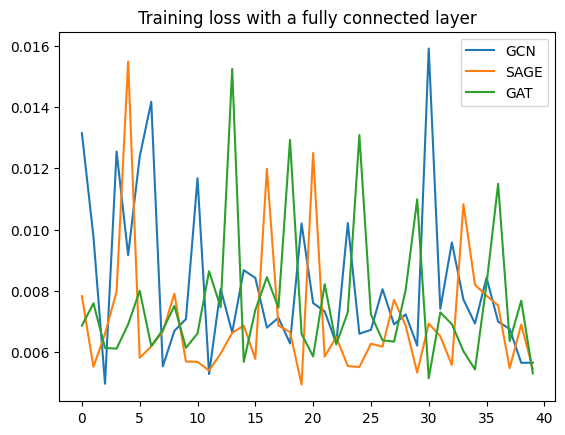

In [ ]:
for label, loss in fa_losses[0].items():
  x = np.arange(len(loss))
  plt.plot(x, loss, label=label)
plt.title('Training loss with a fully connected layer')
plt.legend()
plt.show()

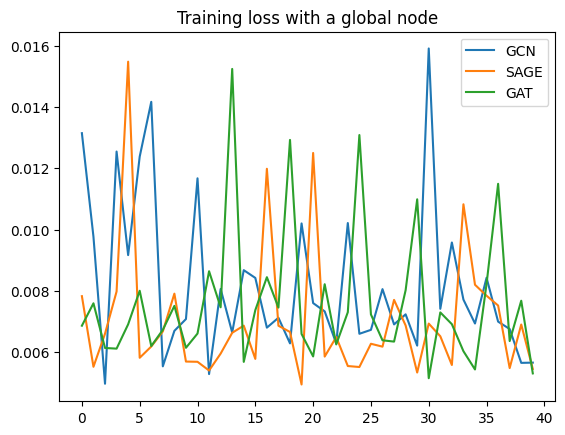

In [ ]:
for label, loss in global_node_losses[0].items():
  x = np.arange(len(loss))
  plt.plot(x, loss, label=label)
plt.title('Training loss with a global node')
plt.legend()
plt.show()

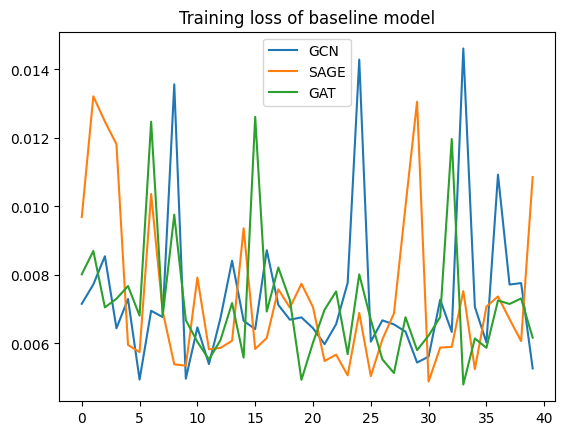

In [ ]:
for label, loss in baseline_losses[0].items():
  x = np.arange(len(loss))
  plt.plot(x, loss, label=label)
plt.title('Training loss of baseline model')
plt.legend()
plt.show()

## Val MAE

In [ ]:
def plot_val_mae_per_model(model):
  val_maes = {
      "FA": fa_val_maes[0][model],
      "global node": global_node_val_maes[0][model],
      "baseline": baseline_val_maes[0][model]
  }

  for label, loss in val_maes.items():
    x = np.arange(len(loss))
    plt.plot(x, loss, label=label)
  plt.title(f'Val MAE of the {model} model')
  plt.legend()
  plt.ylim(1, 1.25)
  plt.show()

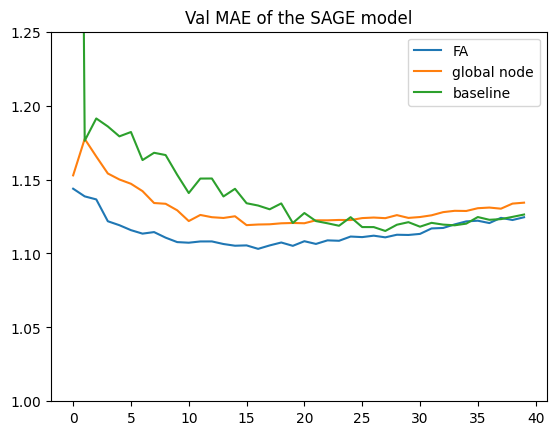

In [ ]:
plot_val_mae_per_model("SAGE")

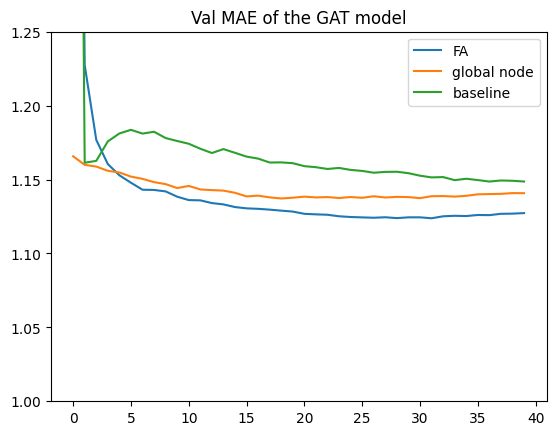

In [ ]:
plot_val_mae_per_model("GAT")

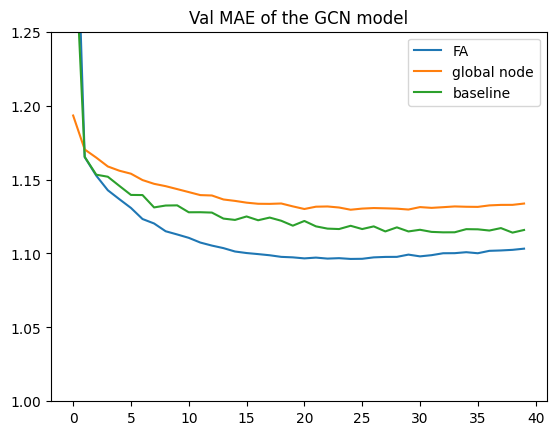

In [ ]:
plot_val_mae_per_model("GCN")